In [2]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib as mpl
from scipy.signal import savgol_filter
from scipy import signal
import sys, time



In [55]:
EJ309_data = np.loadtxt('20220108_gamma_PSD_Channel.txt',dtype ='int16')

In [66]:
print(EJ309_data)
print(EJ309_data.dtype)
print(EJ309_data.shape)
print(sum(EJ309_data[:,:]))
print(sys.getsizeof(EJ309_data))

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  7]
 [ 0  0  0 ...  0  0  9]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0 29]
 [ 0  0  0 ...  0  0  0]]
int16
(100, 4096)
[  0 204 345 ...   2   1 663]
112


In [65]:
# 把 saturation 訊號歸零
EJ309_data[-1,-1]=0

(0.0, 500.0)

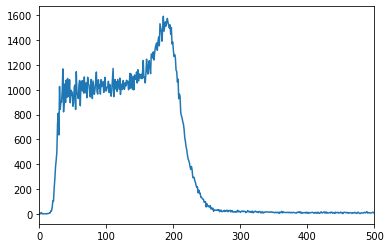

In [62]:
#plt.plot(sum(EJ309_data[:,:]))
plt.plot(EJ309_data[30,:])
plt.xlim(0,500)

In [67]:
print(np.max(EJ309_data[:,:]))

3313


(0.0, 500.0)

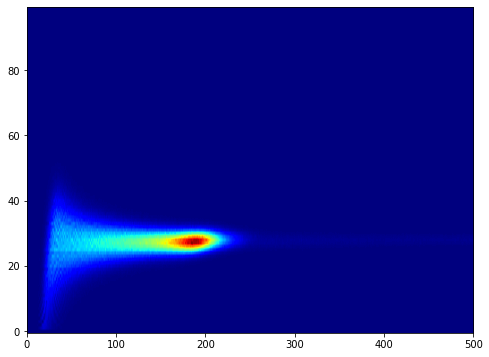

In [173]:
#Plot
fig = plt.figure(figsize=(8,6))        
cm = plt.cm.get_cmap('jet')
plt.imshow(EJ309_data,cmap=cm,origin='lower',aspect='auto',vmin=1, vmax=3313)
plt.xlim(0,500)

In [174]:
from scipy.optimize import curve_fit,fmin
from scipy.optimize import least_squares
def gauss_wo_baseline(x,  A, x0, sigma):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
def gauss_fit_wo_baseline(x, y):  
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    try:  
        popt, pcov = curve_fit(gauss_wo_baseline, x, y, p0=[1, mean, sigma])
        return popt
    except RuntimeError:
        #print("Error - curve_fit failed")
        return  [0,mean,sigma] 

In [178]:
Fed_cut_result_x=[]
Fed_cut_upper = []
Fed_cut_lower = []
Fed_cut_center=[]
sigma_all=[]

PSD_x = np.arange(0,len(EJ309_data[:,0]),1) # 建立X軸的單位

for i in np.arange(0,len(EJ309_data[0,:]),1):# 每一個channel

    #print(i)
    max_value_position=np.argmax(EJ309_data[:,i]) #找到最大值所在的位置
    
    ROI=np.arange(max_value_position-10,max_value_position+10,1) #圈選fitting 的範圍
    #ROI=np.arange(0,len(EJ309_data[:,0]),1)   #或全選範圍
    xdata_PSD=PSD_x[ROI]                       #提出fitting範圍的X軸
    ydata_PSD=EJ309_data[ROI,i]                #提出fitting範圍的Y軸
    Amp, x0, sigma  = gauss_fit_wo_baseline(xdata_PSD, ydata_PSD) #fitting
    #print('========================',i)
    #print(Amp, x0, sigma)
    
    if i==0:
        sigma=0 # 給channel 0的 sigma 0
        Amp=0
        
    sigma_all=np.append(sigma_all,sigma)
    

    if Amp == 0: # Amp =0 表示 fitting 失敗
        sigma = 0
        x0=0
        if i == 0: #因為之後channel 0不重要 但是必須要有值，低channel沒辦法fitting的部分才能填值。
            Fed_cut_result_x = np.append(Fed_cut_result_x,i) 
            Fed_cut_center=np.append(Fed_cut_center,0)# 給channel 0的 center 0
            Fed_cut_upper=np.append(Fed_cut_upper,0) # 給channel 0的 limit 0
            Fed_cut_lower=np.append(Fed_cut_lower,0) # 給channel 0的 limit 0
            
        Fed_cut_result_x = np.append(Fed_cut_result_x,i)
        Fed_cut_upper=np.append(Fed_cut_upper,Fed_cut_upper[-1])
        Fed_cut_lower=np.append(Fed_cut_lower,Fed_cut_lower[-1]) 
        
    if sigma != 0 : #表示有 fitting
        
        #合理fitting，值要確認
        
        if sigma <10:
            Fed_cut_result_x = np.append(Fed_cut_result_x,i)
            Fed_cut_upper=np.append(Fed_cut_upper,x0 +3*(abs(sigma))) # 選三個標準差
            Fed_cut_lower=np.append(Fed_cut_lower,x0 -3*(abs(sigma)))
        
        #不合理fitting
        
        if sigma >=10:
            sigma = sigma_all[-1]
            Fed_cut_result_x = np.append(Fed_cut_result_x,i)
            Fed_cut_upper=np.append(Fed_cut_upper,Fed_cut_upper[-1])
            Fed_cut_lower=np.append(Fed_cut_lower,Fed_cut_lower[-1]) 
        

        

<ipython-input-174-1baa844ac0a2>:6: RuntimeWarning: invalid value encountered in long_scalars
  mean = sum(x * y) / sum(y)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-174-1baa844ac0a2>:4: RuntimeWarning: divide by zero encountered in true_divide
  return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
<ipython-input-174-1baa844ac0a2>:4: RuntimeWarning: invalid value encountered in true_divide
  return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))


(0.0, 300.0)

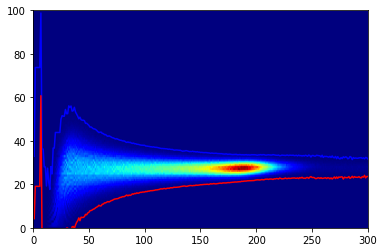

In [179]:
plt.plot(Fed_cut_result_x,Fed_cut_upper,'b')
plt.plot(Fed_cut_result_x,Fed_cut_lower,'r')
plt.imshow(EJ309_data,cmap=cm,origin='lower',aspect='auto',vmin=1, vmax=3313)
plt.ylim(0,100)
plt.xlim(0,300)

(0.0, 100.0)

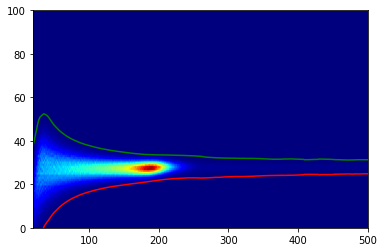

In [181]:
Fed_cut_upper_smooth=  signal.savgol_filter(Fed_cut_upper[:], 21, 1)
Fed_cut_lower_smooth=  signal.savgol_filter(Fed_cut_lower[:], 21, 1)
plt.plot(Fed_cut_result_x,Fed_cut_upper_smooth,'g')
plt.plot(Fed_cut_result_x,Fed_cut_lower_smooth,'r')
plt.imshow(EJ309_data,cmap=cm,origin='lower',aspect='auto',vmin=1, vmax=3313)

plt.xlim(20,500)
plt.ylim(0,100)

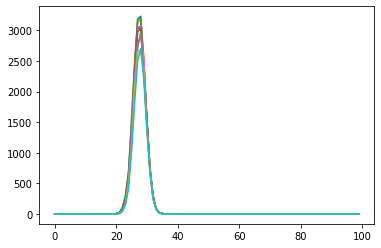

In [147]:
for i in range(190,200,1):
    plt.plot(EJ309_data[:,i])

[1.000e+00 2.000e+00 3.000e+00 ... 4.077e+03 4.083e+03 4.095e+03]
